In [1]:
from copy import deepcopy
from Udep2Mono.util import btree2list
from Udep2Mono.dependency_parse import dependency_parse
from Udep2Mono.binarization import BinaryDependencyTree
from Udep2Mono.polarization import PolarizationPipeline

2021-03-02 02:07:15 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | gum       |
| pos       | gum       |
| lemma     | gum       |
| depparse  | gum       |
| sentiment | sstplus   |
| ner       | ontonotes |

2021-03-02 02:07:15 INFO: Use device: gpu
2021-03-02 02:07:15 INFO: Loading: tokenize
2021-03-02 02:07:17 INFO: Loading: pos
2021-03-02 02:07:17 INFO: Loading: lemma
2021-03-02 02:07:17 INFO: Loading: depparse
2021-03-02 02:07:18 INFO: Loading: sentiment
2021-03-02 02:07:18 INFO: Loading: ner
2021-03-02 02:07:19 INFO: Done loading processors!


In [2]:
import os
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display

def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    os.system('rm -rf ../data/tree.png')
    os.system('rm -rf ../data/tree.ps')
    cf.print_to_file('../data/tree.ps')
    cf.destroy()
    os.system('convert ../data/tree.ps ../data/tree.png')
    display(Image(filename='../data/tree.png'))

In [41]:
from pattern.en import pluralize, singularize
from copy import copy

class PhrasalGenerator:
    def __init__(self):
        self.deptree = None
        self.annotated = None
        self.original = None
        self.kb = {}
        self.tree_log = []
        self.sent_log = []
        self.mod_at_left = [
            "advmod", "amod", "advmod:count", 
            "acl:relcl", "obl", 'obl:npmod', 
            "obl:tmod", "nmod", "nmod:npmod", 
            "nmod:poss", "nmod:tmod", "obl:npmod",
            "acl", "advcl", "xcomp", "ccomp", 
            "appos", 'compound:ptr']
        self.mod_at_right = []
        self.mod_symmetric = ["conj", "compound"]
        
        '''  
            "cop": self.generate_inherite, 
            "expl": self.generate_expl,
            "nummod": self.generate_nummod,
        '''

    def deptree_generate(self, tree, annotated, original):
        self.tree_log = []
        self.sent_log = []
        self.deptree = tree
        self.original = original  
        self.annotated = deepcopy(annotated)

        pop_list = list(annotated.popkeys())
        unziped = list(zip(*pop_list))

        self.sentence = list(unziped[0])
        self.word_ids = unziped[3]
        self.pos_tags = unziped[1]
        self.polarities = unziped[2]
       
        self.generate(self.deptree)

    def generate(self, tree):
        if tree.val in self.mod_at_left:
            self.left_modifier_generate(tree)
        elif tree.val in self.mod_symmetric:
            self.symmetric_generate(tree)
        else:
            self.generate_default(tree)

    def delete_cc(self, tree):
        if tree.val == "cc" and tree.left.val == "but":
            self.delete_modifier(tree, tree.right)

        if tree.is_tree:
            self.delete_cc(tree.left)
            self.delete_cc(tree.right)

    def delete_modifier(self, tree, modifier):
        tree.val = modifier.val
        tree.mark = modifier.mark
        tree.pos = modifier.pos
        tree.id = modifier.id
        
        tree.is_tree = modifier.is_tree
        tree.is_root = modifier.is_root

        tree.left = modifier.left
        tree.right = modifier.right

        self.delete_cc(tree)

    def delete_left_modifier(self, tree):
        self.delete_modifier(tree, tree.right)

    def delete_right_modifier(self, tree):
        self.delete_modifier(tree, tree.left)

    def rollback(self, tree, backup):
        tree.val = backup.val
        tree.left = deepcopy(backup.left)
        tree.right = deepcopy(backup.right)
        tree.mark = backup.mark
        tree.pos = backup.pos
        tree.id = backup.id
        tree.is_tree = backup.is_tree
        tree.is_root = backup.is_root

    def symmetric_generate(self, tree):
        self.right_modifier_generate(tree)
        self.left_modifier_generate(tree)

    def right_modifier_generate(self, tree):
        left = tree.left
        right = tree.right
        backup = deepcopy(tree)

        if left.mark == "+" or left.mark == "=":
            self.delete_right_modifier(tree)
            self.save_tree(isTree=True)
            self.rollback(tree, backup)    
        
        self.generate(tree.left)
        self.generate(tree.right)

    def left_modifier_generate(self, tree):
        left = tree.left
        right = tree.right
        backup = deepcopy(tree)

        if right.mark == "+" or right.mark == "=":
            self.delete_left_modifier(tree)
            
            self.save_tree(isTree=True)
            self.rollback(tree, backup)   

        elif right.mark == "-":
            if right.val in ["aux", "obj", "obl", "xcomp"]:
                if "advcl" in self.kb:
                    for adv in self.kb["advcl"]:
                        self.add_modifier_sent(right, adv)

                if "advmod" in self.kb:
                    for adv in self.kb["advmod"]:
                        self.add_modifier_sent(right, adv)
                        #self.add_modifier_sent(right, adv)

        self.generate(tree.left)
        self.generate(tree.right)
    
    def return_last_leaf(self, tree):
        min_id = 0
        min_id_l = 0
        min_id_r = 0

        if tree.id != None:
            min_id = int(tree.id)
    
        if tree.left.is_tree:
            min_id_l = self.return_last_leaf(tree.left)
        else:
            min_id_l = tree.left.id

        if tree.right.is_tree:
            min_id_r = self.return_last_leaf(tree.right)
        else:
            min_id_r = tree.right.id

        return max(min_id, max(min_id_l, min_id_r))

    def add_modifier_sent(self, tree, modifier): 
        last_leaf = self.return_last_leaf(tree)
        sentence = deepcopy(self.sentence)
        sentence.insert(last_leaf, modifier)
        self.sent_log.append(' '.join(sentence))

    def add_modifier_lexical(self, tree, modifier, head, word_id, direct=0):
        if direct == 0:
            generated = ' '. join([modifier, head])
        else:
            generated = ' '. join([head, modifier])
        
        sentence = deepcopy(self.sentence)
        diff = 0
        if word_id > len(sentence):
            diff = word_id - len(sentence)
        sentence[word_id-1-diff] = generated
        self.sent_log.append(' '.join(sentence))

    def generate_default(self, tree):
        if tree.pos is not None:
            if "NN" in tree.pos and tree.mark == "-":
                if "amod" in self.kb:
                    for adj in self.kb["amod"]:
                        self.add_modifier_lexical(tree, adj, tree.val, tree.id)
                if "compound" in self.kb:
                    for rel in self.kb["compound"]:
                        self.add_modifier_lexical(tree, rel, tree.val, tree.id)
                if "acl:relcl" in self.kb:
                    for rel in self.kb["acl:relcl"]:
                        self.add_modifier_lexical(tree, rel, tree.val, tree.id, 1)
                if "nmod" in self.kb:
                    for adv in self.kb["nmod"]:
                        self.add_modifier_lexical(tree, adv, tree.val, tree.id, 1)
                if "det" in self.kb:
                    for adv in self.kb["det"]:
                        self.add_modifier_lexical(tree, adv, tree.val, tree.id)
                
            elif "VB" in tree.pos and tree.mark == "-":
                if "advmod" in self.kb:
                    for adv in self.kb["advmod"]:
                        self.add_modifier_lexical(tree, adv, tree.val, tree.id)
                        self.add_modifier_lexical(tree, adv, tree.val, tree.id, 1)

        elif tree.val in ["aux", "obj", "obl", "xcomp"] and tree.mark == "-":
                if "advcl" in self.kb:
                    for adv in self.kb["advcl"]:
                        self.add_modifier_sent(tree, adv)

                if "advmod" in self.kb:
                    for adv in self.kb["advmod"]:
                        self.add_modifier_sent(tree, adv)
                        #self.add_modifier_sent(right, adv)

        if tree.is_tree:
            self.generate(tree.left)
            self.generate(tree.right)  

    def save_tree(self, isTree):
        if isTree:
            leaves = self.deptree.sorted_leaves().popkeys()
            sentence = ' '.join([x[0] for x in leaves])
            self.tree_log.append(self.deptree.copy())
            #polarized = pipeline.postprocess(self.deptree, {})
            #btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
            #jupyter_draw_nltk_tree(btreeViz) 
            #leaves = copy(self.deptree).sorted_leaves().popkeys()
            #sentence = ' '.join([x[0] for x in leaves]) 
        else:
            annotated_cp = deepcopy(self.annotated)
            self.sent_log.append(
                ' '.join([word[0] for word in list(annotated_cp.popkeys())]))

    def buildTree(self, config):
        left = BinaryDependencyTree(
            config['mod'], "N", "N", 1024, 
            wid=config['lid'], pos="JJ")
        right = BinaryDependencyTree(
            config['head'], "N", "N", 1024,
            wid=config['rid'], pos="NN")
        tree = BinaryDependencyTree(config['rel'], left, right, 1025)
        left.mark = config['mark']
        right.mark = config['mark']
        tree.mark = config['mark']
        return tree

In [51]:
modifier_relation = {
    "NN": ["amod", "nmod", "acl:relcl", "fixed", "compound", "det"],
    "VB": ["advmod", "acl", "obl", "xcomp", "advcl"]
}

def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

def collect_modifiers(tree, sent_set, mod_type="NN"):
    if tree.val in modifier_relation[mod_type]:
        leaves = tree.left.sorted_leaves().popkeys()
        sentence = ' '.join([x[0] for x in leaves])
        if tree.val in sent_set:
            sent_set[tree.val].append(sentence)
        else:
            sent_set[tree.val] = [sentence]

    if tree.is_tree:
        collect_modifiers(tree.left, sent_set, mod_type)
        collect_modifiers(tree.right, sent_set, mod_type)

In [5]:
sentences = ["Some red flowers need light", 
             "Some red and beautiful flowers need light",
             "All flowers need light and water", 
             "No flowers need bright or warm light",
             "John can sing and dance",
             "John ate an apple and finished his homework",
             "John finished his homework and did not eat an apple"]

upward = ["Some students sing to celebrate their graduation",
          "An Irishman won the nobel prize for literature.",
          "A big poison spider was spanning a web", 
          "A Californian special policeman pulled a car over and spoke to the driver",
          "A woman is dancing in a cage", 
          "A woman is dancing beautifully in a cage", 
          "People are riding and paddling a raft", 
          "Some delegates finished the survey on time"]

sick_upward = ["A brown dog is attacking another animal in front of the tall man in pants",
               "A skilled person is riding a bicycle on one wheel",
               "Two children are lying in the snow and are drawing angels"]

downward = ["No spider was spanning a web",
            "No student finished homework",
            "I've never flown in an airplane"]

hypothesis = ["No poison spider was spanning a web", 
              "No student at school finished homework compeletly",
              "I've never flown in an airplane because i'm afraid."] 

In [15]:
MED_upward = []
MED_upward_hypo = []
MED_downward = []
MED_downward_hypo = []

with open("../data/MED/upward.txt") as upward_med:
    lines = upward_med.readlines()
    for i in range(len(lines) // 4):
        MED_upward.append(lines[i*4+1])
        MED_upward_hypo.append(lines[i*4+2])

with open("../data/MED/downward.txt") as donward_med:
    lines = donward_med.readlines()
    for i in range(len(lines) // 4):
        MED_downward.append(lines[i*4+1])
        MED_downward_hypo.append(lines[i*4+2])

In [19]:
from tqdm import tqdm

annotations = []
with open("./generation_log_donward.txt", 'w') as generate_log:
    phrasalGenerator = PhrasalGenerator()
    pipeline = PolarizationPipeline(verbose=0)
    for i in tqdm(range(len(MED_downward))):
        h_parsed, _ = dependency_parse(MED_downward_hypo[i], parser="stanza")
        h_tree, _ = pipeline.run_binarization(h_parsed, MED_downward_hypo[i], {})
        nn_phrases = collect_modifiers(h_tree, mod_type="NN")
        vb_phrases = collect_modifiers(h_tree, mod_type="VB")
        annotation = pipeline.single_polarization(MED_downward[i])
        
        #print("\n====================================")
        generate_log.write("\n====================================")
        
        phrasalGenerator.kb = merge(nn_phrases, vb_phrases)
        #print(phrasalGenerator.kb)
       
        #print("\nInit Premise: " + annotation['original'])
        generate_log.write("\nInit Premise: " + annotation['original'])
        generate_log.write("\nHypothesis: " + MED_downward_hypo[i])
        
        #polarized = pipeline.postprocess(annotation['polarized_tree'], {})
        #btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
        #jupyter_draw_nltk_tree(btreeViz) 
        
        phrasalGenerator.deptree_generate(
            annotation['polarized_tree'], 
            annotation['annotated'], 
            annotation['original'])

        for gen_tree in phrasalGenerator.tree_log:
            leaves = gen_tree.sorted_leaves().popkeys()
            sentence = ' '.join([x[0] for x in leaves])
            #print("\nNext Premise: " + sentence)
            generate_log.write("\nNext Premise: " + sentence)
        
        for gen_sent in set(phrasalGenerator.sent_log):
            #print("\nNext Premise: " + gen_sent)
            generate_log.write("\nNext Premise: " + gen_sent)


 15%|█▌        | 315/2072 [00:26<02:30, 11.69it/s]


KeyError: 'parataxis'


{'amod': ['few', 'female', 'southern'], 'compound': ['committee']}

Init Premise: Few female committee members are from southern Europe.


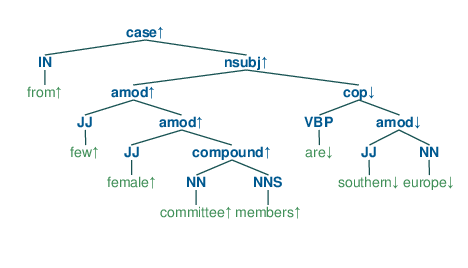


Next Premise: female committee members are from southern europe

Next Premise: few committee members are from southern europe

Next Premise: few female committee are from southern europe

Next Premise: few female members are from southern europe

Next Premise: few female committee members are from southern female europe

Next Premise: few female committee members are from southern committee europe

Next Premise: few female committee members are from southern few europe

Next Premise: few female committee members are from southern southern europe


In [53]:
up = ["Few female committee members are from southern Europe."]
up_h = ["Few female committee members are from southern Europe."]

annotations = []
phrasalGenerator = PhrasalGenerator()
pipeline = PolarizationPipeline(verbose=0)
for i in range(len(up)):
    h_parsed, _ = dependency_parse(up_h[i], parser="stanza")
    h_tree, _ = pipeline.run_binarization(h_parsed, up_h[i], {})
    nn_phrases = {} 
    vb_phrases = {} 
    collect_modifiers(h_tree, nn_phrases, mod_type="NN")
    collect_modifiers(h_tree, vb_phrases, mod_type="VB")
    annotation = pipeline.single_polarization(up[i])
    
    print("\n====================================")
    phrasalGenerator.kb = merge(nn_phrases, vb_phrases)
    print(phrasalGenerator.kb)
    
    print("\nInit Premise: " + annotation['original'])
    
    polarized = pipeline.postprocess(annotation['polarized_tree'], {})
    btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btreeViz) 
    
    phrasalGenerator.deptree_generate(
        annotation['polarized_tree'], 
        annotation['annotated'], 
        annotation['original'])

    for gen_tree in phrasalGenerator.tree_log:
        leaves = gen_tree.sorted_leaves().popkeys()
        sentence = ' '.join([x[0] for x in leaves])
        print("\nNext Premise: " + sentence)
    
    for gen_sent in set(phrasalGenerator.sent_log):
        print("\nNext Premise: " + gen_sent)

In [ ]:
polarized = "[nsubj  (NOUN  researchers)  (ccomp  (mark  (SCONJ  that)  (nsubj  (acl  (advmod  (ADV  first)  (obl  (case  (ADP  in)  (PROPN  Britain))  (VERB  identified)))  (acl:relcl  (nsubj:pass  (PRON  which)  (aux:pass  (AUX  is)  (xcomp  (mark  (PART  to)  (advmod  (ADV  more)  (cop  (AUX  be)  (ADJ  infectious))))  (VERB  believed))))  (det  (DET  the)  (NOUN  variant))))  (aux  (AUX  could)  (xcomp  (nmod  (case  (ADP  of)  (det  (DET  the)  (NOUN  virus)))  (nmod  (case  (ADP  in)  (det  (DET  this)  (NOUN  country)))  (det  (DET  the)  (amod  (ADJ  dominant)  (NOUN  form)))))  (obl  (case  (ADP  by)  (PROPN  March))  (VERB  become))))))  (aux  (AUX  have)  (obl  (case  (ADP  In)  (compound  (PROPN  United)  (PROPN  States)))  (VERB  warned))))]"

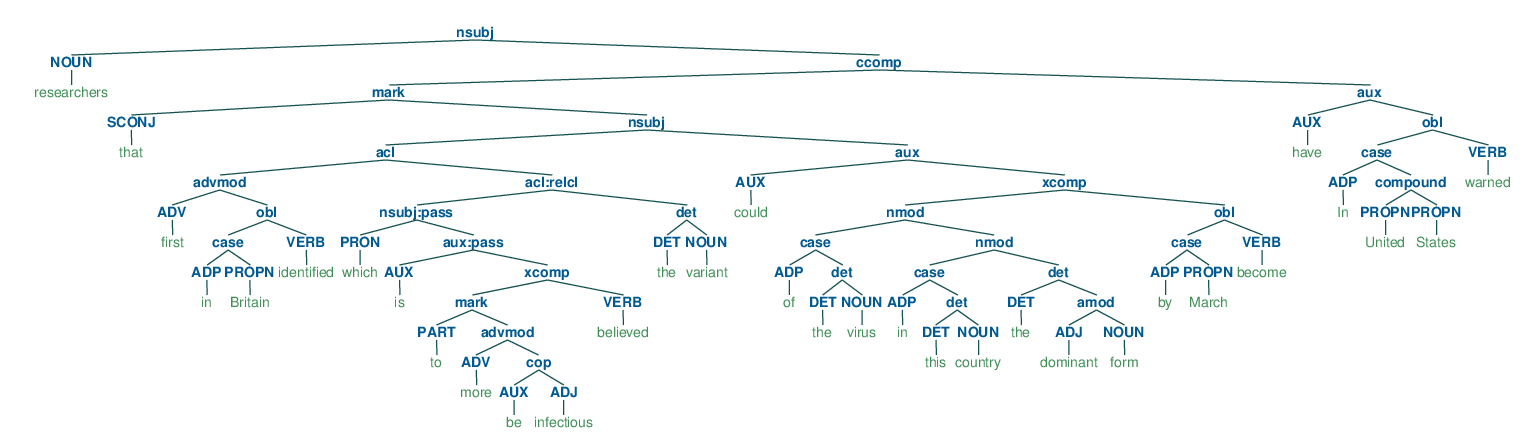

In [8]:
btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
jupyter_draw_nltk_tree(btreeViz) 